In [2]:
#imports

from scipy.optimize import fsolve
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

# CONSTANTS

# This constant assumes that if you place m items in b bins, (for m >> b) the max load of each bin will be c*m/b, with high probability
BINNING_CONSTANT = 4

PAILLIER_MODULUS_BIT_SIZE = 3072
PAILLIER_MODULUS_SIZE_IN_BYTES = PAILLIER_MODULUS_BIT_SIZE // 8

PAILLIER_INPUT_CT_SIZE_IN_BYTES = 128/8 + PAILLIER_MODULUS_SIZE_IN_BYTES
PAILLIER_OUTPUT_CT_SIZE_IN_BYTES = 2 * PAILLIER_MODULUS_SIZE_IN_BYTES

def B_to_KB(x):
    return x // 1024

def list_B_to_KB(x):
    return [B_to_KB(y) for y in x]

## Parameters of BasicPIRwithRLWE

In [3]:
# Evaluation Key Sizes
# These numbers are for N=4096 specifically
# To change the paremeters, the numbers have to be updated
RLWE_LOG2_N = 12
RLWE_N = 2 ** RLWE_LOG2_N
RLWE_LOG2_P = 18
MAX_PLAINTEXT_BITSIZE = RLWE_N * RLWE_LOG2_P

# Key sizes are in bytes
RLWE_EVAL_KEY_SIZE = dict()
RLWE_EVAL_KEY_SIZE[0] = 6
RLWE_EVAL_KEY_SIZE[1] = 131198 // 2
RLWE_EVAL_KEY_SIZE[2] = 262390 // 2
RLWE_EVAL_KEY_SIZE[3] = 393582 // 2
RLWE_EVAL_KEY_SIZE[4] = 524774 // 2
RLWE_EVAL_KEY_SIZE[5] = 655966 // 2
RLWE_EVAL_KEY_SIZE[6] = 787158 // 2
RLWE_EVAL_KEY_SIZE[7] = 918350 // 2
RLWE_EVAL_KEY_SIZE[8] = 1049542 // 2
RLWE_EVAL_KEY_SIZE[9] = 1180734 // 2
RLWE_EVAL_KEY_SIZE[10] = 1311926 // 2
RLWE_EVAL_KEY_SIZE[11] = 1443118 // 2
RLWE_EVAL_KEY_SIZE[12] = 1574310 // 2

INPUT_CT_SIZE = 65843 // 2
OUTPUT_CT_SIZE = 65843

ONIONPIR_EVAL_KEY_SIZE = dict()
ONIONPIR_EVAL_KEY_SIZE[0] = 32824
ONIONPIR_EVAL_KEY_SIZE[1] = 229770
ONIONPIR_EVAL_KEY_SIZE[2] = 426716
ONIONPIR_EVAL_KEY_SIZE[3] = 623662
ONIONPIR_EVAL_KEY_SIZE[4] = 820608
ONIONPIR_EVAL_KEY_SIZE[5] = 1017554
ONIONPIR_EVAL_KEY_SIZE[6] = 1214500
ONIONPIR_EVAL_KEY_SIZE[7] = 1411446
ONIONPIR_EVAL_KEY_SIZE[8] = 1608392
ONIONPIR_EVAL_KEY_SIZE[9] = 1805338
ONIONPIR_EVAL_KEY_SIZE[10] = 2002284
ONIONPIR_EVAL_KEY_SIZE[11] = 2199230
ONIONPIR_EVAL_KEY_SIZE[12] = 2396176


In [4]:
for i in range(12):
    print(B_to_KB(RLWE_EVAL_KEY_SIZE[i+1] - RLWE_EVAL_KEY_SIZE[i]))
print(B_to_KB(INPUT_CT_SIZE))

print(B_to_KB((109 * RLWE_N) // 8))

64
64
64
64
64
64
64
64
64
64
64
64
32
54


## Finding the communication cost of BasicPIRwithRLWE

In [14]:
######### Communication cost of Base Algorithms #########
# Communication cost as a function of only the number of rows and the payload size

def comm_cost_BasicPIRwithPaillier(num_rows, payload_size_in_bytes):
  query_size = num_rows * PAILLIER_INPUT_CT_SIZE_IN_BYTES
  response_size = math.ceil(payload_size_in_bytes/PAILLIER_MODULUS_SIZE_IN_BYTES) * PAILLIER_OUTPUT_CT_SIZE_IN_BYTES
  return query_size + response_size, query_size, response_size

def comm_cost_BasicPIRwithRLWE(num_rows, payload_size_in_bytes):
  log2_keys_to_send = min(math.ceil(math.log2(num_rows)), RLWE_LOG2_N)
  keys_size = RLWE_EVAL_KEY_SIZE[log2_keys_to_send]
  query_size = INPUT_CT_SIZE * math.ceil(num_rows / (2**log2_keys_to_send))
  response_size = math.ceil(8*payload_size_in_bytes/MAX_PLAINTEXT_BITSIZE) * OUTPUT_CT_SIZE
  
  return keys_size + query_size + response_size, query_size, response_size, keys_size

def comm_cost_BasicPIRwithRLWE_withWhisPIR(num_rows, payload_size_in_bytes):
  keys_size = RLWE_EVAL_KEY_SIZE[2]
  query_size = INPUT_CT_SIZE * math.ceil(num_rows / RLWE_N)
  response_size = math.ceil(8*payload_size_in_bytes/MAX_PLAINTEXT_BITSIZE) * OUTPUT_CT_SIZE
  
  return keys_size + query_size + response_size, query_size, response_size, keys_size

def trivial_pir_cost(input_m, payload_size_in_bytes):
  return (input_m * payload_size_in_bytes)

######### Communication Cost of Base algorithms with Binning #########

# Communication cost of BasicPIRwithPaillier, assuming that `input_m` items of size `item_size` are stored in `B` bins
def comm_cost_BasicPIRwithPaillier_with_B_bins(input_m, B, item_size):
  max_load = BINNING_CONSTANT * input_m / B  
  return comm_cost_BasicPIRwithPaillier(B, max_load*item_size)

## Optimizer Function ##
# This function finds the number of bins which minimizes the communication cost
def find_optimal_number_of_bins_for_BasicPIRwithPaillier_with_binning(input_m, payload_size_in_bytes):
  best_B = math.floor(math.sqrt(BINNING_CONSTANT * input_m * payload_size_in_bytes * PAILLIER_OUTPUT_CT_SIZE_IN_BYTES / (PAILLIER_MODULUS_SIZE_IN_BYTES*PAILLIER_OUTPUT_CT_SIZE_IN_BYTES)))
  total_comm, _, _, = comm_cost_BasicPIRwithPaillier_with_B_bins(input_m, best_B, payload_size_in_bytes)
  return best_B, total_comm

# Communication cost of BasicPIRwithRLWE, assuming that `input_m` items of size `item_size` are stored in `B` bins
def comm_cost_BasicPIRwithRLWE_with_B_bins(input_m, B, payload_size_in_bytes):
  max_load = BINNING_CONSTANT * input_m / B
  return comm_cost_BasicPIRwithRLWE(B, max_load*payload_size_in_bytes)

## Optimizer Function ##
# This function finds the number of bins which minimizes the communication cost
def find_optimal_number_of_bins_for_BasicPIRwithRLWE(input_m, payload_size_in_bytes):
  # This is calculated by a naive minimization of the communication cost formula
  # it may not be the optimal solution so we check some other options in for loop as well
  potential_best_B = math.floor(math.sqrt(BINNING_CONSTANT * input_m * payload_size_in_bytes * RLWE_N * OUTPUT_CT_SIZE / (MAX_PLAINTEXT_BITSIZE*INPUT_CT_SIZE)))
  potential_best_B = 2**(math.ceil(math.log2(potential_best_B)))
  arg_min_B = potential_best_B
  min_total, _, _, _ = comm_cost_BasicPIRwithRLWE_with_B_bins(input_m, potential_best_B, payload_size_in_bytes)
  for candidate_ceil_log2_B in range(RLWE_LOG2_N, 0, -1):
    chosen_B = min(potential_best_B, 2**candidate_ceil_log2_B)
    total_comm, _, _, _ = comm_cost_BasicPIRwithRLWE_with_B_bins(input_m, chosen_B, payload_size_in_bytes)
    if min_total > total_comm:
      min_total = total_comm
      arg_min_B = chosen_B
  
  return arg_min_B, min_total

# Communication cost of BasicPIRwithRLWE, assuming that `input_m` items of size `item_size` are stored in `B` bins
def comm_cost_BasicPIRwithRLWE_with_WhisPIR_with_B_bins(input_m, B, payload_size_in_bytes):
  max_load = BINNING_CONSTANT * input_m / B
  return comm_cost_BasicPIRwithRLWE_withWhisPIR(B, max_load*payload_size_in_bytes)

## Optimizer Function ##
# This function finds the number of bins which minimizes the communication cost
def find_optimal_number_of_bins_for_BasicPIRwithRLWE_withWhisPIR(input_m, payload_size_in_bytes):
  # This is calculated by a naive minimization of the communication cost formula
  # it may not be the optimal solution so we check some other options in for loop as well
  potential_best_B = math.floor(math.sqrt(BINNING_CONSTANT * input_m * payload_size_in_bytes * RLWE_N * OUTPUT_CT_SIZE / (MAX_PLAINTEXT_BITSIZE*INPUT_CT_SIZE)))
  potential_best_B = RLWE_N * math.ceil(potential_best_B / RLWE_N)
  arg_min_B = potential_best_B
  min_total, _, _, _ = comm_cost_BasicPIRwithRLWE_with_WhisPIR_with_B_bins(input_m, potential_best_B, payload_size_in_bytes)
  
  # for candidate_ceil_log2_B in range(RLWE_LOG2_N, 0, -1):
  #   chosen_B = min(potential_best_B, 2**candidate_ceil_log2_B)
  #   total_comm, _, _, _ = comm_cost_BasicPIRwithRLWE_with_WhisPIR_with_B_bins(input_m, chosen_B, payload_size_in_bytes)
  #   if min_total > total_comm:
  #     min_total = total_comm
  #     arg_min_B = chosen_B
  
  return arg_min_B, min_total

######### Communication Cost of SPIR #########

def comm_cost_BasicSymmetricPIRwithPaillier(num_rows, num_bins, payload_size_in_bytes):
  items_per_bin = math.ceil(num_rows / num_bins)
  main_total, main_query, main_response = comm_cost_BasicPIRwithPaillier(num_bins, items_per_bin * payload_size_in_bytes)
  key_fetch_total, key_fetch_query, key_fetch_response = comm_cost_BasicPIRwithPaillier(items_per_bin, 128)
  return main_total + key_fetch_total, main_query + key_fetch_query, main_response + key_fetch_response

def find_optimal_number_of_bins_for_BasicSymmetricPIRwithPaillier_with_binning(num_rows, payload_size_in_bytes):
  min_total = None
  for candidate_B in range(1, num_rows):
    total_comm, _, _ = comm_cost_BasicSymmetricPIRwithPaillier(num_rows, candidate_B, payload_size_in_bytes)
    if min_total is None or min_total > total_comm:
      min_total = total_comm
      arg_min_B = candidate_B
  return arg_min_B, min_total

In [6]:
math.floor(math.sqrt(BINNING_CONSTANT * 500000 * 81 * RLWE_N * OUTPUT_CT_SIZE / (MAX_PLAINTEXT_BITSIZE * INPUT_CT_SIZE)))

4242

## Plots for PrivateProviderRecords and PrivateWantHave
We can use the same graphs for the two cases

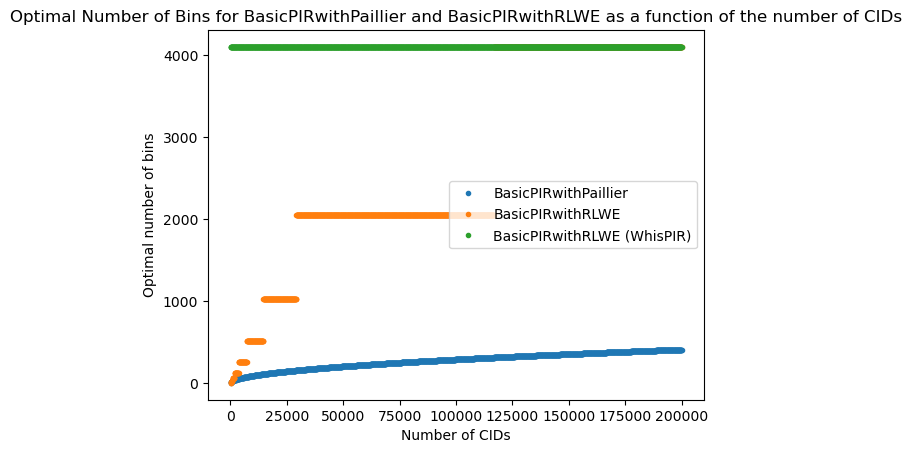

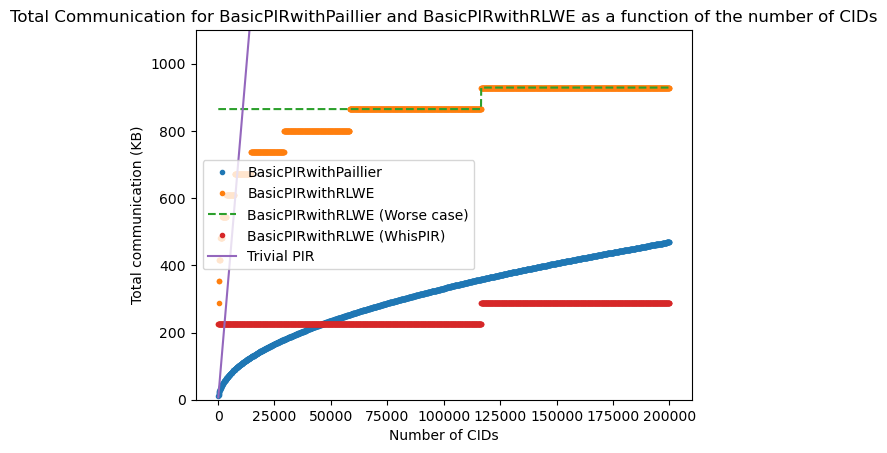

<Figure size 640x480 with 0 Axes>

In [16]:

ITEM_SIZES_IN_BYTES = 81
m_list = np.arange(100, 200000, 100)
# cropped_m_list = np.arange(100, 80000, 100)

num_bins_BasicPIRwithPaillier_list = []
per_bin_payload_size_basicpirwithpaillier = []
total_comm_BasicPIRwithPaillier_list = []

num_bins_BasicPIRwithRLWE_list = []
per_bin_payload_size_basicpirwithrlwe = []
total_comm_BasicPIRwithRLWE_list = []

num_bins_BasicPIRwithRLWE_withWhisPIR_list = []
per_bin_payload_size_basicpirwithrlwe_withWhisPIR = []
total_comm_BasicPIRwithRLWE_withWhisPIR_list = []

total_comm_BasicPIRwithRLWE_worst_case_list = []

for input_m in m_list:
  
  optimal_B, total_comm = find_optimal_number_of_bins_for_BasicPIRwithPaillier_with_binning(input_m, ITEM_SIZES_IN_BYTES)
  num_bins_BasicPIRwithPaillier_list.append(optimal_B)
  per_bin_payload_size_basicpirwithpaillier.append(ITEM_SIZES_IN_BYTES * input_m * BINNING_CONSTANT / optimal_B)
  total_comm_BasicPIRwithPaillier_list.append(total_comm)
  
  optimal_B, total_comm = find_optimal_number_of_bins_for_BasicPIRwithRLWE(input_m, ITEM_SIZES_IN_BYTES)
  num_bins_BasicPIRwithRLWE_list.append(optimal_B)
  per_bin_payload_size_basicpirwithrlwe.append(ITEM_SIZES_IN_BYTES * input_m * BINNING_CONSTANT / optimal_B)
  total_comm_BasicPIRwithRLWE_list.append(total_comm)
  
  worst_case_BasicPIRwithRLWE, _, _, _ = comm_cost_BasicPIRwithRLWE_with_B_bins(input_m, 2**RLWE_LOG2_N, ITEM_SIZES_IN_BYTES)
  total_comm_BasicPIRwithRLWE_worst_case_list.append(worst_case_BasicPIRwithRLWE)

  optimal_B, total_comm = find_optimal_number_of_bins_for_BasicPIRwithRLWE_withWhisPIR(input_m, ITEM_SIZES_IN_BYTES)
  num_bins_BasicPIRwithRLWE_withWhisPIR_list.append(optimal_B)
  per_bin_payload_size_basicpirwithrlwe_withWhisPIR.append(ITEM_SIZES_IN_BYTES * input_m * BINNING_CONSTANT / optimal_B)
  total_comm_BasicPIRwithRLWE_withWhisPIR_list.append(total_comm)
  
trivial_pir_cost_list = [trivial_pir_cost(m, ITEM_SIZES_IN_BYTES) for m in m_list]
  
plt.plot(m_list, num_bins_BasicPIRwithPaillier_list, ".", label='BasicPIRwithPaillier')
plt.plot(m_list, num_bins_BasicPIRwithRLWE_list, ".", label='BasicPIRwithRLWE')
plt.plot(m_list, num_bins_BasicPIRwithRLWE_withWhisPIR_list, ".", label='BasicPIRwithRLWE (WhisPIR)')
plt.xlabel("Number of CIDs")
plt.ylabel("Optimal number of bins")
plt.title("Optimal Number of Bins for BasicPIRwithPaillier and BasicPIRwithRLWE as a function of the number of CIDs")
plt.legend()
# plt.savefig("num_bins_pir_with_binning.png")
plt.show()
plt.clf()

plt.plot(m_list, list_B_to_KB(total_comm_BasicPIRwithPaillier_list), ".", label='BasicPIRwithPaillier')
plt.plot(m_list, list_B_to_KB(total_comm_BasicPIRwithRLWE_list), ".", label='BasicPIRwithRLWE')
plt.plot(m_list, list_B_to_KB(total_comm_BasicPIRwithRLWE_worst_case_list), "--", label='BasicPIRwithRLWE (Worse case)')
plt.plot(m_list, list_B_to_KB(total_comm_BasicPIRwithRLWE_withWhisPIR_list), ".", label='BasicPIRwithRLWE (WhisPIR)')
plt.plot(m_list, list_B_to_KB(trivial_pir_cost_list), label='Trivial PIR')
plt.xlabel("Number of CIDs")
plt.ylabel("Total communication (KB)")
plt.ylim(0, 1100)
plt.title("Total Communication for BasicPIRwithPaillier and BasicPIRwithRLWE as a function of the number of CIDs")
plt.legend()
# plt.savefig("total_comm_pir_with_binning.png")
plt.show()
plt.clf()

# make a csv file out of the three lists
pd.DataFrame({
  'm': m_list,
  'num_bins_basicpirwithrlwe': num_bins_BasicPIRwithRLWE_list,
  'num_bins_basicpirwithpaillier': num_bins_BasicPIRwithPaillier_list,
  'per_bin_payload_size_basicpirwithrlwe': per_bin_payload_size_basicpirwithrlwe,
  'per_bin_payload_size_basicpirwithpaillier': per_bin_payload_size_basicpirwithpaillier,
  'total_comm_basicpirwithrlwe': list_B_to_KB(total_comm_BasicPIRwithRLWE_list),
  'total_comm_basicpirwithpaillier': list_B_to_KB(total_comm_BasicPIRwithPaillier_list),
  "total_comm_basicpirwithrlwe_worst_case": list_B_to_KB(total_comm_BasicPIRwithRLWE_worst_case_list),
  "trivial_pir_cost": list_B_to_KB(trivial_pir_cost_list)
}).to_csv("results_pir_with_bins.csv", index=False)


In [12]:
print("Paillier", min(per_bin_payload_size_basicpirwithpaillier), max(per_bin_payload_size_basicpirwithpaillier))
print("RLWE", min(per_bin_payload_size_basicpirwithrlwe), max(per_bin_payload_size_basicpirwithrlwe))

Paillier 127.55905511811024 5690.853176346543
RLWE 4611.62109375 15812.40234375


## Plots for PrivatePeerRouting
Communiction Costs of PIR over the Routing Table

In [13]:
# paillier_modulus_bit_size = 3072
# pallier_modulus_size_in_bytes = paillier_modulus_bit_size // 8

# number_of_rows = 40

# def trivial_pir_cost_in_KB(number_of_rows, ROW_SIZE_IN_BYTES):
#   return (number_of_rows * ROW_SIZE_IN_BYTES)/1024

# def paillier_pir_cost_in_KB(number_of_rows, ROW_SIZE_IN_BYTES):
#   return (number_of_rows * PAILLIER_INPUT_CT_SIZE_IN_BYTES + PAILLIER_OUTPUT_CT_SIZE_IN_BYTES * math.ceil(ROW_SIZE_IN_BYTES / PAILLIER_MODULUS_SIZE_IN_BYTES))/1024

# def basicpir_with_rlwe_cost_in_KB(number_of_rows, ROW_SIZE_IN_BYTES):
#   log2_num_rows = math.ceil(math.log2(number_of_rows))
#   return (math.ceil(number_of_rows/RLWE_N) * INPUT_CT_SIZE + RLWE_EVAL_KEY_SIZE[min(log2_num_rows, 12)] + math.ceil(ROW_SIZE_IN_BYTES / (RLWE_N * RLWE_LOG2_P)) * OUTPUT_CT_SIZE)/1024


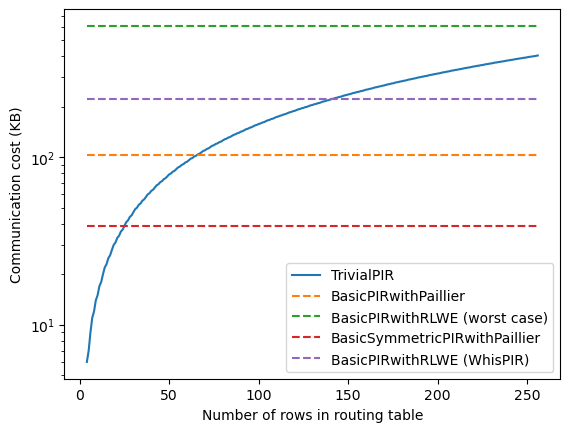

In [14]:
ROW_SIZE_IN_BYTES = 20 * 81

rows_range = range(4,257)
trivial_PIR_cost_list = [B_to_KB(trivial_pir_cost(n, ROW_SIZE_IN_BYTES)) for n in rows_range]
# paillier_pir_cost_list = [B_to_KB(comm_cost_BasicPIRwithPaillier(n, ROW_SIZE_IN_BYTES)[0]) for n in rows_range]
paillier_worst_case_cost_list = [B_to_KB(comm_cost_BasicPIRwithPaillier(256, ROW_SIZE_IN_BYTES)[0]) for _ in rows_range]
# basicpir_with_rlwe_cost_list = [B_to_KB(comm_cost_BasicPIRwithRLWE(n, ROW_SIZE_IN_BYTES)[0]) for n in rows_range]
basicpir_with_rlwe_worst_case_cost_list = [B_to_KB(comm_cost_BasicPIRwithRLWE(256, ROW_SIZE_IN_BYTES)[0]) for _ in rows_range]

optimal_spir_bin_num = find_optimal_number_of_bins_for_BasicSymmetricPIRwithPaillier_with_binning(256, ROW_SIZE_IN_BYTES)[0]
basicsymmetricpir_with_paillier_cost_list = [B_to_KB(comm_cost_BasicSymmetricPIRwithPaillier(256, optimal_spir_bin_num, ROW_SIZE_IN_BYTES)[0]) for _ in rows_range]

basicpir_with_rlwe_with_whispir_cost_list = [B_to_KB(comm_cost_BasicPIRwithRLWE_withWhisPIR(256, ROW_SIZE_IN_BYTES)[0]) for _ in rows_range]

plt.plot(rows_range, trivial_PIR_cost_list, label='TrivialPIR')
# plt.plot(rows_range, paillier_pir_cost_list, label='BasicPIRwithPaillier')
plt.plot(rows_range, paillier_worst_case_cost_list, '--', label='BasicPIRwithPaillier')
# plt.plot(rows_range, basicpir_with_rlwe_cost_list, label='BasicPIRwithRLWE')
plt.plot(rows_range, basicpir_with_rlwe_worst_case_cost_list, '--', label='BasicPIRwithRLWE (worst case)')
plt.plot(rows_range, basicsymmetricpir_with_paillier_cost_list, '--', label='BasicSymmetricPIRwithPaillier')
plt.plot(rows_range, basicpir_with_rlwe_with_whispir_cost_list, '--', label='BasicPIRwithRLWE (WhisPIR)')

plt.ylabel("Communication cost (KB)")
plt.xlabel("Number of rows in routing table")
plt.yscale('log')
plt.legend()
pd.DataFrame({
  'rows': rows_range,
  'trivial_PIR_cost': trivial_PIR_cost_list,
  # 'paillier_pir_cost': paillier_pir_cost_list,
  'paillier_worst_case_cost': paillier_worst_case_cost_list,
  # 'basicpir_with_rlwe_cost': basicpir_with_rlwe_cost_list,
  'basicpir_with_rlwe_worst_case_cost': basicpir_with_rlwe_worst_case_cost_list,
  'basicsymmetricpir_with_paillier_cost': basicsymmetricpir_with_paillier_cost_list
}).to_csv("total_comm_pir_in_RT.csv", index=False)

In [15]:
print(min(paillier_worst_case_cost_list), min(basicpir_with_rlwe_worst_case_cost_list), min(basicpir_with_rlwe_with_whispir_cost_list), min(basicsymmetricpir_with_paillier_cost_list))

103.0 608 224 39.0


In [16]:
ROW_SIZE_IN_BYTES = 256 * 1024

log_rows_range = range(10, 19)
basicpir_with_rlwe_cost_list = [B_to_KB(comm_cost_BasicPIRwithRLWE(2**log_n, ROW_SIZE_IN_BYTES)[0]) for log_n in log_rows_range]
pd.DataFrame({
  'log2_rows': log_rows_range,
  'basicpir_with_rlwe_cost': basicpir_with_rlwe_cost_list
}).to_csv("total_comm_256_KB_rlwe.csv", index=False)